# My implementation
Potential improvements
* Vectorisation of stack instead of for loop
* 

(400, 365, 273)


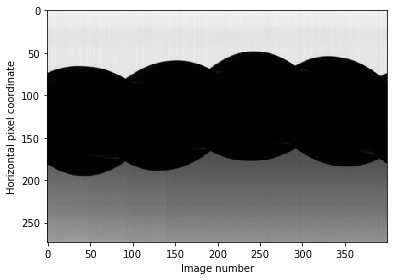

In [27]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

PATH_TO_IMAGE =  '../data_store/2022-10-10_1433_testrecon/2022-10-10_1433_testrecon_result.tif'
im = io.imread(PATH_TO_IMAGE)
print(im.shape) # Expect the shape to be in (angles, length, width)

# Generate list of angles for which the sample is expected to rotate
# The last datapoint is excluded 
theta = np.linspace(0, 360, np.shape(im)[0], endpoint=False)

# Convert image stack to sinograms
# Want shape (length, width, angles)
sinogram = np.moveaxis(im, 0, -1)

%matplotlib inline
# Display the sinogram for the first row of pixels
plt.ylabel('Horizontal pixel coordinate')
plt.xlabel('Image number')
io.imshow(sinogram[0])


In [35]:
import numpy as np

from scipy.interpolate import interp1d
from scipy.constants import golden_ratio
from scipy.fft import fft, ifft, fftfreq, fftshift


from functools import partial
def _sinogram_circle_to_square(sinogram):
    diagonal = int(np.ceil(np.sqrt(2) * sinogram.shape[0]))
    pad = diagonal - sinogram.shape[0]
    old_center = sinogram.shape[0] // 2
    new_center = diagonal // 2
    pad_before = new_center - old_center
    pad_width = ((pad_before, pad - pad_before), (0, 0))
    return np.pad(sinogram, pad_width, mode='constant', constant_values=0)


def _get_fourier_filter(size, filter_name):
    """Construct the Fourier filter.
    This computation lessens artifacts and removes a small bias as
    explained in [1], Chap 3. Equation 61.
    Parameters
    ----------
    size : int
        filter size. Must be even.
    filter_name : str
        Filter used in frequency domain filtering. Filters available:
        ramp, shepp-logan, cosine, hamming, hann. Assign None to use
        no filter.
    Returns
    -------
    fourier_filter: ndarray
        The computed Fourier filter.
    References
    ----------
    .. [1] AC Kak, M Slaney, "Principles of Computerized Tomographic
           Imaging", IEEE Press 1988.
    """
    n = np.concatenate((np.arange(1, size / 2 + 1, 2, dtype=int),
                        np.arange(size / 2 - 1, 0, -2, dtype=int)))
    f = np.zeros(size)
    f[0] = 0.25
    f[1::2] = -1 / (np.pi * n) ** 2

    # Computing the ramp filter from the fourier transform of its
    # frequency domain representation lessens artifacts and removes a
    # small bias as explained in [1], Chap 3. Equation 61
    fourier_filter = 2 * np.real(fft(f))         # ramp filter
    if filter_name == "ramp":
        pass
    elif filter_name == "shepp-logan":
        # Start from first element to avoid divide by zero
        omega = np.pi * fftfreq(size)[1:]
        fourier_filter[1:] *= np.sin(omega) / omega
    elif filter_name == "cosine":
        freq = np.linspace(0, np.pi, size, endpoint=False)
        cosine_filter = fftshift(np.sin(freq))
        fourier_filter *= cosine_filter
    elif filter_name == "hamming":
        fourier_filter *= fftshift(np.hamming(size))
    elif filter_name == "hann":
        fourier_filter *= fftshift(np.hanning(size))
    elif filter_name is None:
        fourier_filter[:] = 1

    return fourier_filter[:, np.newaxis]
    
class iraydon:
    def __init__(self, radon_image, theta, output_size=None,
           filter_name="ramp", interpolation="linear", circle=True):
        if radon_image.ndim != 2:
            raise ValueError('The input image must be 2-D')
        self.angles_count = len(theta)

        if self.angles_count != radon_image.shape[1]:
            raise ValueError("The given ``theta`` does not match the number of "
                            "projections in ``radon_image``.")

        interpolation_types = ('linear', 'nearest', 'cubic')
        if interpolation not in interpolation_types:
            raise ValueError(f"Unknown interpolation: {interpolation}")

        filter_types = ('ramp', 'shepp-logan', 'cosine', 'hamming', 'hann', None)
        if filter_name not in filter_types:
            raise ValueError(f"Unknown filter: {filter_name}")
        radon_image = radon_image.astype(np.float64)

        self.dtype = radon_image.dtype

        img_shape = radon_image.shape[0]
        if output_size is None:
            # If output size not specified, estimate from input radon image
            if circle:
                output_size = img_shape
            else:
                output_size = int(np.floor(np.sqrt((img_shape) ** 2 / 2.0)))

        
        self.filter_name = filter_name
        self.theta = theta
        self.output_size = output_size
        self.circle = circle
        self.interpolation = interpolation
        pass

    def transform(self, radon_image):

        if self.circle:
            radon_image = _sinogram_circle_to_square(radon_image)
            self.img_shape = radon_image.shape[0]

        # Resize image to next power of two (but no less than 64) for
        # Fourier analysis; speeds up Fourier and lessens artifacts
        projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * self.img_shape))))
        pad_width = ((0, projection_size_padded - self.img_shape), (0, 0))
        img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

        # Apply filter in Fourier domain
        fourier_filter = _get_fourier_filter(projection_size_padded, self.filter_name)
        projection = fft(img, axis=0) * fourier_filter
        radon_filtered = np.real(ifft(projection, axis=0)[:self.img_shape, :])

        # Reconstruct image by interpolation
        reconstructed = np.zeros((self.output_size, self.output_size),
                                dtype=self.dtype)
        radius = self.output_size // 2
        xpr, ypr = np.mgrid[:self.output_size, :self.output_size] - radius
        x = np.arange(self.img_shape) - self.img_shape // 2

        for col, angle in zip(radon_filtered.T, np.deg2rad(self.theta)):
            t = ypr * np.cos(angle) - xpr * np.sin(angle)
            if self.interpolation == 'linear':
                interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
            else:
                interpolant = interp1d(x, col, kind=self.interpolation,
                                    bounds_error=False, fill_value=0)
            reconstructed += interpolant(t)

        if self.circle:
            out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
            reconstructed[out_reconstruction_circle] = 0.

        return reconstructed * np.pi / (2 * self.angles_count)

    def transform_2dfilter(self, radon_image):
        
        if self.circle:
            radon_image = _sinogram_circle_to_square(radon_image)
            self.img_shape = radon_image.shape[0]

        # Resize image to next power of two (but no less than 64) for
        # Fourier analysis; speeds up Fourier and lessens artifacts
        projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * self.img_shape))))
        pad_width = ((0, projection_size_padded - self.img_shape), (0, 0))
        img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)

        # Apply filter in Fourier domain, no filter at first!
        fourier_filter = _get_fourier_filter(projection_size_padded, None)
        projection = fft(img, axis=0) * fourier_filter
        radon_filtered = np.real(ifft(projection, axis=0)[:self.img_shape, :])

        # Reconstruct image by interpolation
        reconstructed = np.zeros((self.output_size, self.output_size),
                                dtype=self.dtype)
        radius = self.output_size // 2
        xpr, ypr = np.mgrid[:self.output_size, :self.output_size] - radius
        x = np.arange(self.img_shape) - self.img_shape // 2

        for col, angle in zip(radon_filtered.T, np.deg2rad(self.theta)):
            t = ypr * np.cos(angle) - xpr * np.sin(angle)
            if self.interpolation == 'linear':
                interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)
            else:
                interpolant = interp1d(x, col, kind=self.interpolation,
                                    bounds_error=False, fill_value=0)
            reconstructed += interpolant(t)

        if self.circle:
            out_reconstruction_circle = (xpr ** 2 + ypr ** 2) > radius ** 2
            reconstructed[out_reconstruction_circle] = 0.

        return reconstructed * np.pi / (2 * self.angles_count)



In [43]:
inv = iraydon(sinogram[0], theta, filter_name='hamming')

# Reconstruct dataset here
reconstruction_fbp = np.zeros((im.shape[1], im.shape[2], im.shape[2]))
# for i in tqdm(range(im.shape[1])):
for i in tqdm(range(10)):
    reconstruction_fbp[i] = inv.transform(sinogram[i])

100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


In [44]:
sinogram.shape

(365, 273, 400)

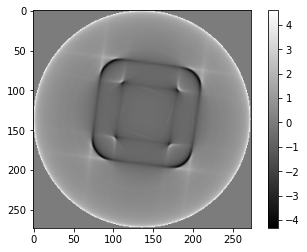

In [45]:
plt.imshow(reconstruction_fbp[2], cmap='gray')
plt.colorbar()